# Polynomial Regression, the Bias-Variance Dilemma, and Learning Curves

In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
import matplotlib.pyplot as plt
import seaborn as sns

# Make this notebook's output stable across runs
np.random.seed(0)

# Plot formatting
%matplotlib inline
sns.set()

# Do not use scientific notation in pandas tables
pd.options.display.float_format = '{:,.4f}'.format

## Polynomial Regression

In [2]:
# Generate data according to the function
# y = 0.5x^2 + x + 2 + noise,
# where noise is standard normal

m = 300  # Count of instances

X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

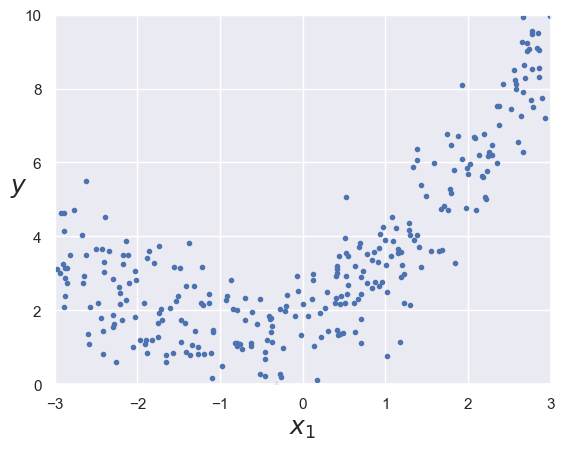

In [3]:
# Plot the generated data
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

In [4]:
# Use sklearn to preprocess the polynomial feature, x, with degree 2
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

print(X[0])
print(X_poly[0])

[0.29288102]
[0.29288102 0.08577929]


In [5]:
# Fit the polynomial regression
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78757977]), array([[0.95092301, 0.53576481]]))

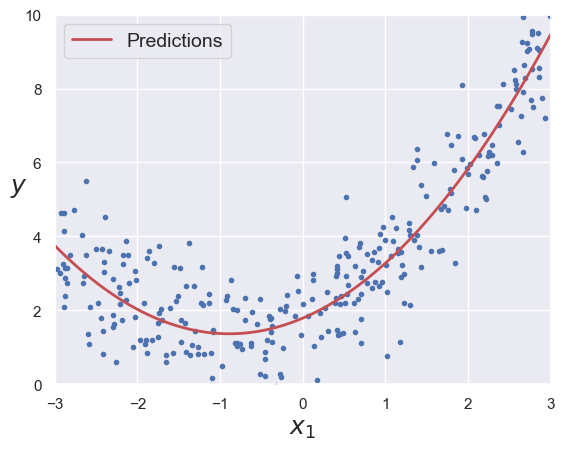

In [6]:
# Plot the model
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

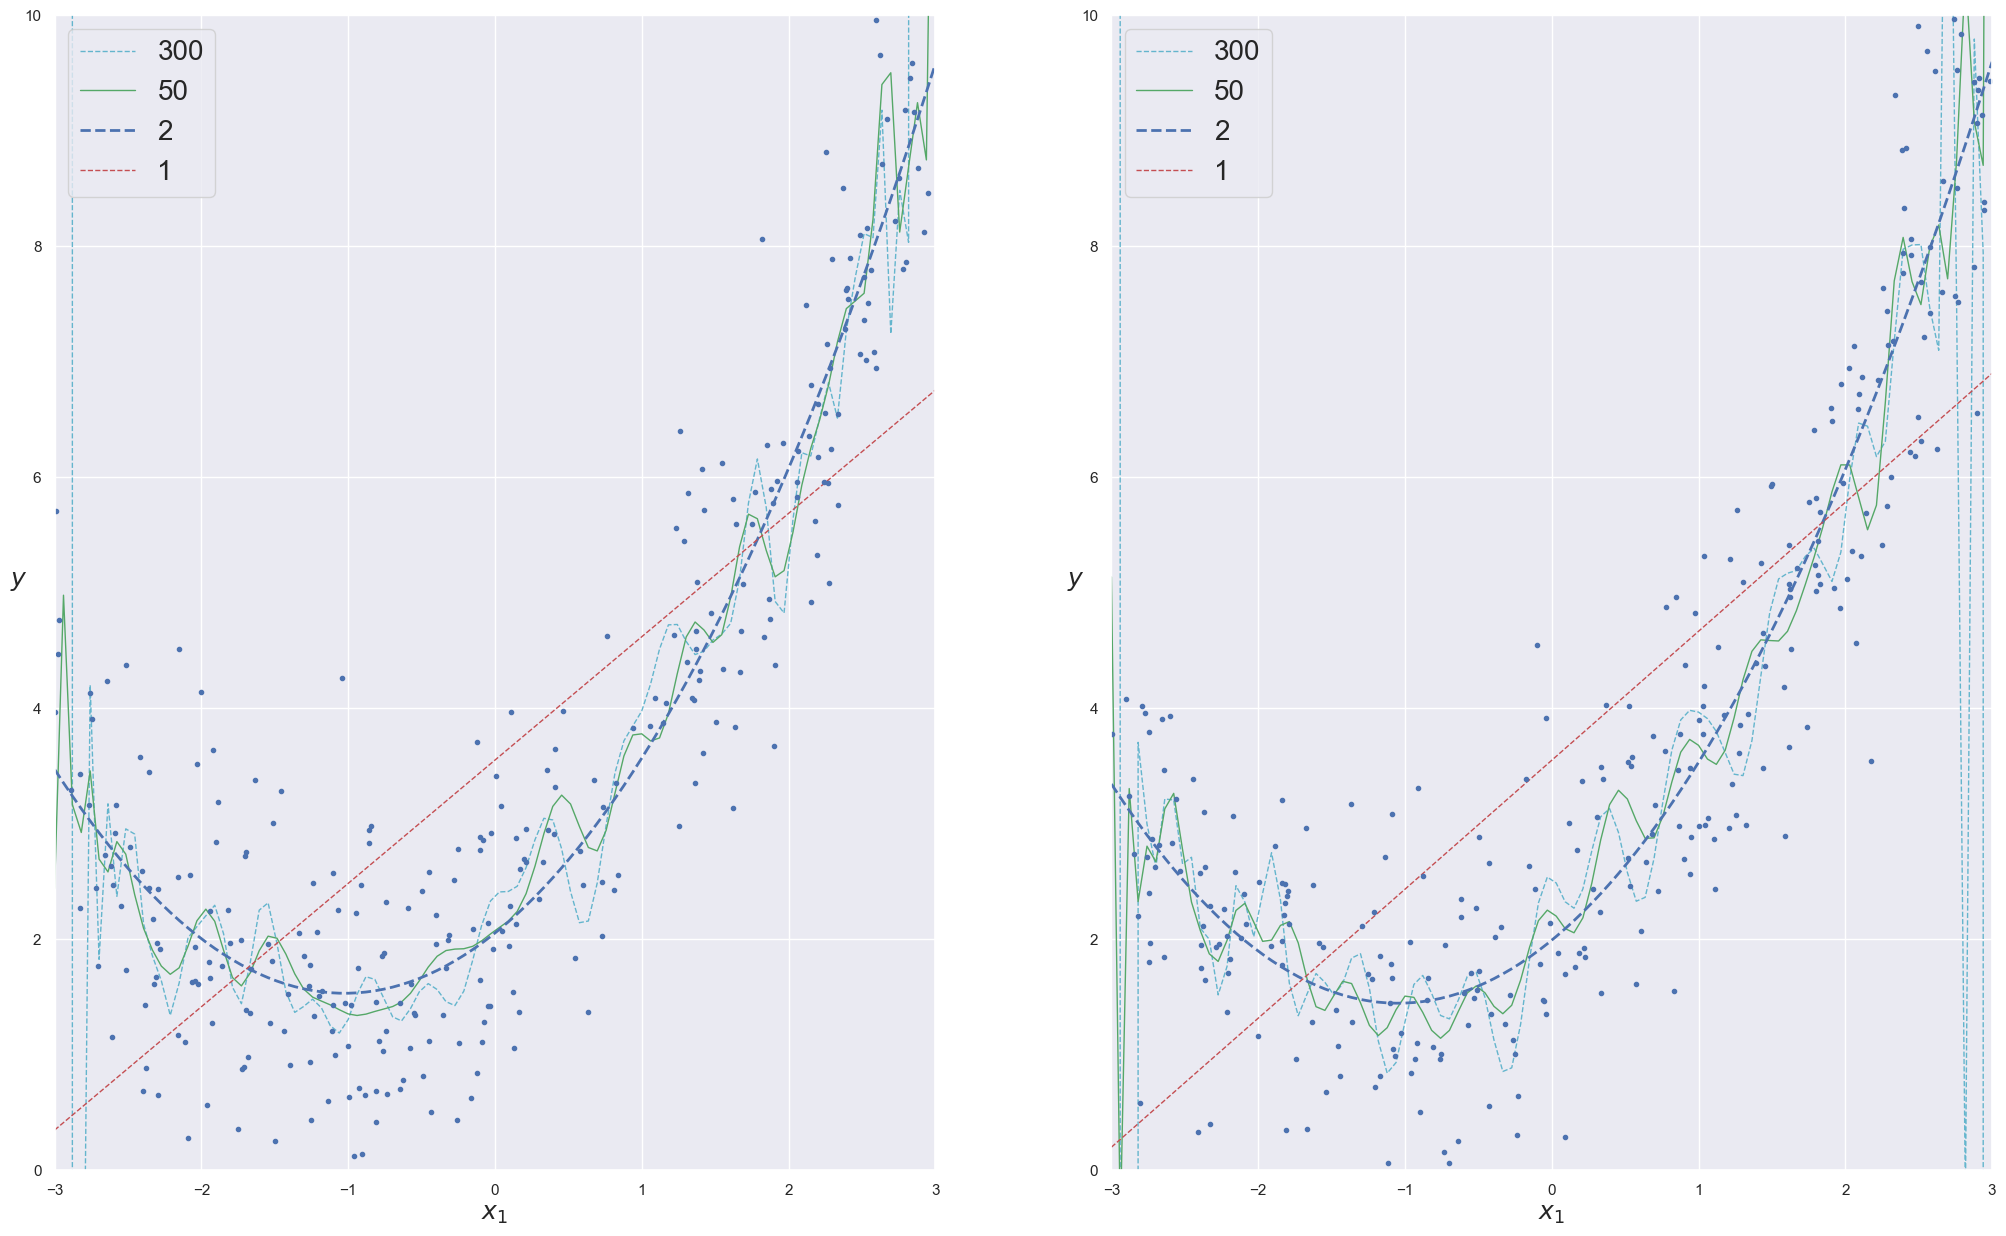

In [7]:
# Fit models with higher degree polynomials
degrees = (300, 50, 2, 1)
combos = (('c--', 1, degrees[0]),
          ('g-', 1, degrees[1]),          
          ('b--', 2, degrees[2]),
          ('r--', 1, degrees[3]))

fig, ax = plt.subplots(1, 2, figsize=(25, 15))

Xs = []
ys = []
polynomial_regressions = []

for i in (0, 1):
    plt.axes(ax[i])
    
    Xs += [6 * np.random.rand(m, 1) - 3]
    ys += [0.5 * Xs[i]**2 + Xs[i] + 2 + np.random.randn(m, 1)]

    for style, width, degree in combos:
        poly_features = PolynomialFeatures(degree=degree, include_bias=False)
        std_scaler = StandardScaler()
        lin_reg = LinearRegression()
        polynomial_regression = Pipeline([
                ('poly_features', poly_features),
                ('std_scaler', std_scaler),
                ('lin_reg', lin_reg),
            ])
        polynomial_regression.fit(Xs[i], ys[i])
        
        # Note that we predict on X_new for visualization purposes, since X_new
        # contains evenly spaced points from -3 to 3
        y_new_pred = polynomial_regression.predict(X_new)
        plt.plot(X_new, y_new_pred, style, label=str(degree), linewidth=width)        

    plt.plot(Xs[i], ys[i], "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=20)
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$y$", rotation=0, fontsize=18)
    plt.axis([-3, 3, 0, 10])


plt.show()

In [8]:
# Train on the data from the left panel above, then test on the data
# from the right panel above
rows = []
for degree in degrees:
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
        ('poly_features', poly_features),
        ('std_scaler', std_scaler),
        ('lin_reg', lin_reg)
    ])
    polynomial_regression.fit(Xs[0], ys[0])
    
    # Calculate train R2
    y_pred_test = polynomial_regression.predict(Xs[0])
    R2_test = r2_score(ys[0], y_pred_test)

    # Calculate test R2
    y_pred_train = polynomial_regression.predict(Xs[1])
    R2_train = r2_score(ys[1], y_pred_train)
    
    rows += [[degree, R2_test, R2_train]]


pd.DataFrame(data=rows, columns=['Degree', 'Test R2', 'Train R2'])

,Degree,Test R2,Train R2
0,300,0.8739,"-5,755,880,309,535,972.0000"
1,50,0.8688,0.6243
2,2,0.8539,0.8621
3,1,0.5751,0.5876


## Learning Curves

In [9]:
# Utility function that splits data into training and testing,
# fits a model on progressively larger portions of the training data,
# evaluates using the test data, and plots the results
def plot_learning_curves(model, X, y, test_size):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

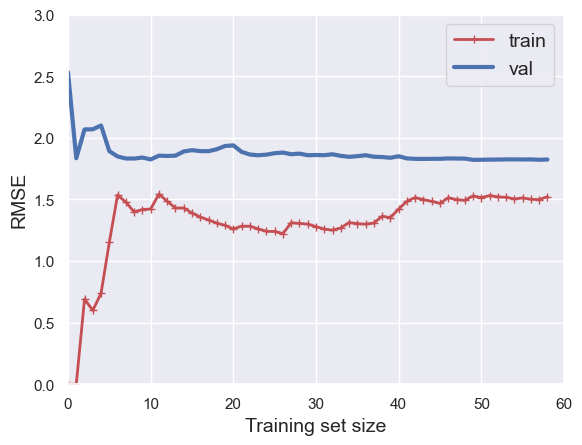

In [10]:
# Plot learning curves for a linear model without polynomial terms
# This model often underfits the data
test_size = 0.8
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y, test_size)
plt.axis([0, (1 - test_size)*m, 0, 3])
plt.show()            

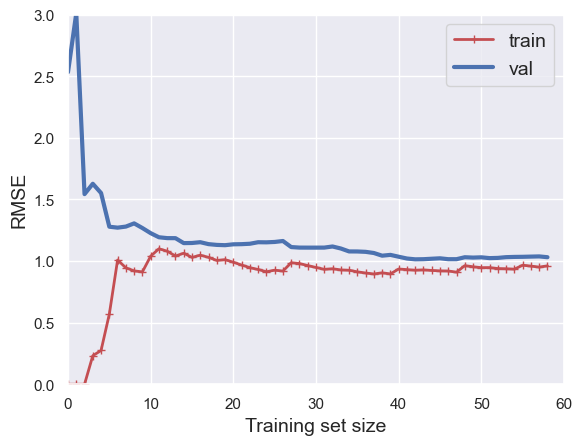

In [11]:
# Plot learning curves for a linear model with 2-degree polynomial terms
# This model often overfits the data
polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y, test_size)
plt.axis([0, (1-test_size)*m, 0, 3]) 
plt.show()

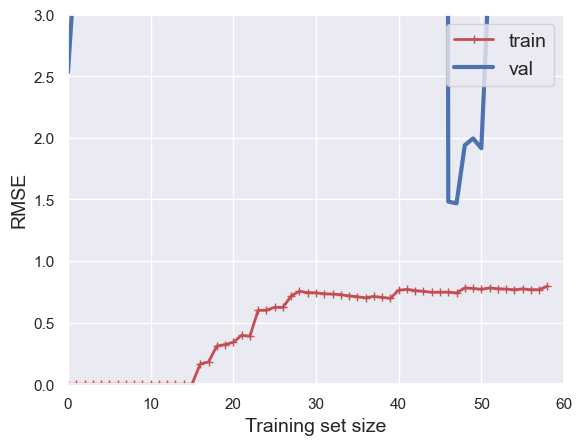

In [12]:
# Plot learning curves for a linear model with 15-degree polynomial terms
polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=15, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y, test_size)
plt.axis([0, (1 - test_size)*m, 0, 3])
plt.show()

### Exercise

What do learning curves communicate about a model's ability to generalize?

## Regularization: Ridge Regression

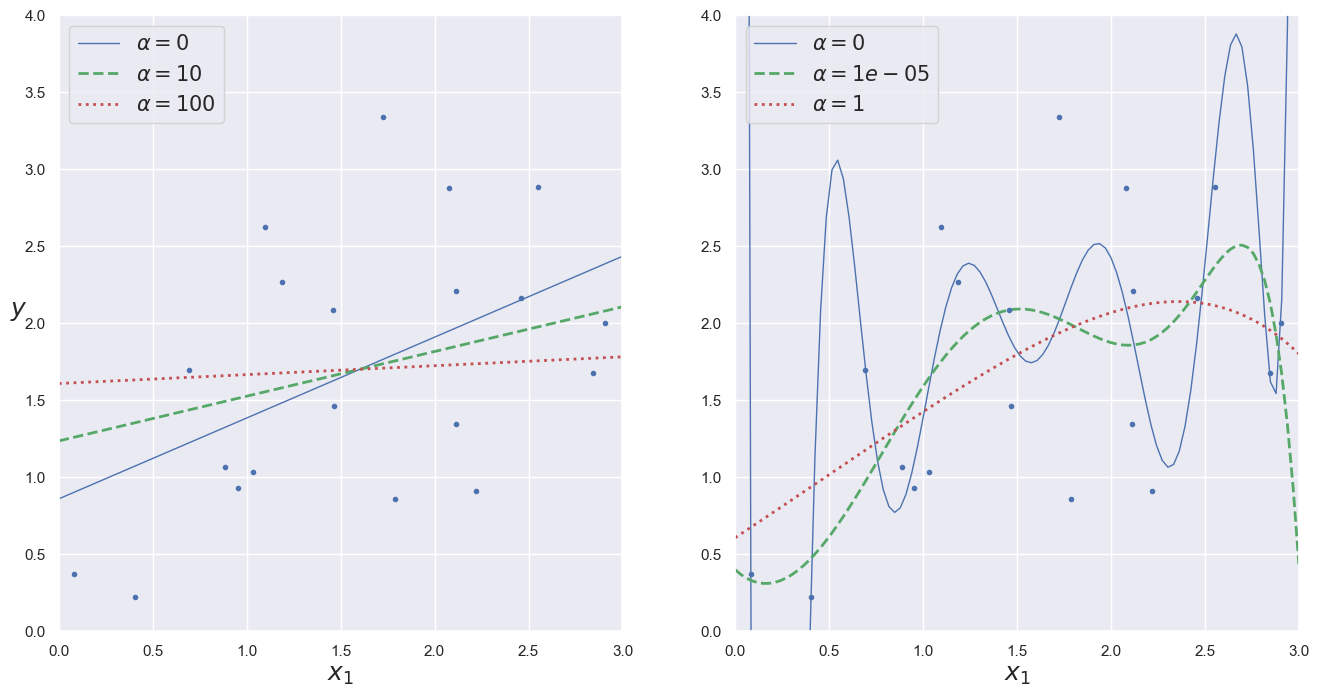

In [13]:
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(16,8))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

plt.show()